# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install pymorphy2 -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option("display.max_columns", 500)
import os
import sys
import PIL
import cv2
import re
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error)

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import seaborn as sns

import pymorphy2

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
def show_info(col):
    print('Сколько пропусков? {}'.format(col.isna().sum()))
    print()
    print('Процент пропусков? {}%'.format((col.isna().sum() /len(col)) *100))
    print()      
    print('Описание:\n{}'.format(col.describe()))
    print()
    print('Как распределено?\n{}'.format(col.value_counts()))
    print()
    print('Какие значения?\n{}'.format(col.unique()))
    
def show_info_hist(col):
    print('Сколько пропусков? {}'.format(col.isna().sum()))
    print()
    print('Процент пропусков? {}%'.format((col.isna().sum() /len(col)) *100))
    print() 
    print('Описание:\n{}'.format(col.describe()))
    print()
    print('Как распределено?\n{}'.format(col.value_counts()))
    print()
    print('Какие значения?\n{}'.format(col.unique()))
    print()
    plt.figure(figsize=(15,6))
    sns.countplot(x=col, data=data)
    plt.xticks(rotation = 'vertical')
    plt.show()
    

In [8]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [9]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [10]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
DIR_TRAIN3 = '../input/auto-ru03-04-2021/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
train3 = pd.read_csv(DIR_TRAIN3 + 'my_train.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [12]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [13]:
train3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54442 entries, 0 to 54441
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             54442 non-null  object 
 1   brand                54442 non-null  object 
 2   color                54442 non-null  object 
 3   engineDisplacement   54442 non-null  float64
 4   enginePower          54442 non-null  float64
 5   fuelType             54442 non-null  object 
 6   mileage              54442 non-null  int64  
 7   productionDate       54442 non-null  int64  
 8   model_name           54442 non-null  object 
 9   vehicleTransmission  54442 non-null  object 
 10  Владение             54442 non-null  int64  
 11  ПТС                  54442 non-null  object 
 12  Привод               54442 non-null  object 
 13  Руль                 54442 non-null  object 
 14  Состояние            54442 non-null  object 
 15  Таможня              54442 non-null 

In [14]:
train3.nunique()

bodyType                  17
brand                    939
color                     16
engineDisplacement        61
enginePower              379
fuelType                   6
mileage                22600
productionDate            15
model_name               106
vehicleTransmission        4
Владение                   3
ПТС                        2
Привод                     3
Руль                       2
Состояние                  1
Таможня                    1
price                   5945
car_url                50246
dtype: int64

In [15]:
train3.rename(columns={'Владение':'Владельцы'}, inplace=True)

In [16]:
df_train1 = train.copy()
#df_train2 = train2.copy()
df_train3=train3.copy()
df_test = test.copy()
df_test['price'] = 0

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train1['sample'] = 1 # помечаем где у нас трейн
#df_train2['sample'] = 1
df_train3['sample'] = 1
df_test['sample'] = 0 # помечаем где у нас тест

frames_to_concat=[df_train1, df_train3, df_test]
frames_to_concat_to_train=[df_train1, df_train3]
data1=pd.concat(frames_to_concat)
data1_train=pd.concat(frames_to_concat_to_train)
data1.drop_duplicates(inplace=True)
data1_train.drop_duplicates(inplace=True)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [17]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [18]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# Та же наивная модель, только на большем датасете

In [19]:
data_train1, data_test1 = train_test_split(data1_train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [20]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test1[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train1.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test1['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 155.75%


Результат, мягко говоря, не очень. Впрочем,дополнительно парсились лишь определенные столбцы датафрейма train, а значит в объединенном файле очень много пропусков, которые наивной моделью отработались крайне неадекватно. Что же, продолжим работу с учебным датасетом  

# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

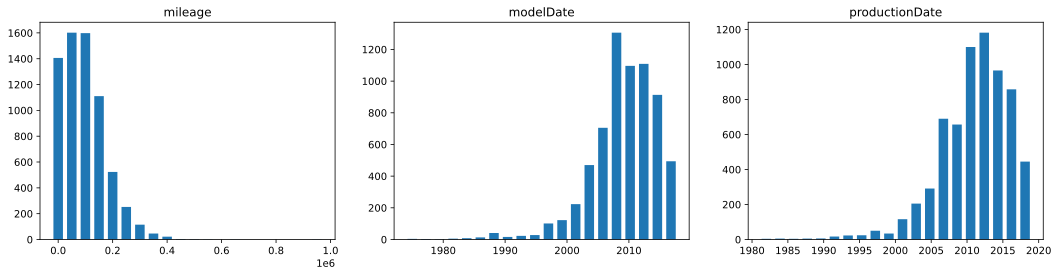

In [21]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [22]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info', 'name',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

In [23]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


# Some preproc

In [24]:
data.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64

# bodyType

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count      8353
unique       17
top       седан
freq       3541
Name: bodyType, dtype: object

Как распределено?
седан                   3541
внедорожник 5 дв.       2896
купе                     543
хэтчбек 5 дв.            364
лифтбек                  299
универсал 5 дв.          196
минивэн                  178
купе-хардтоп             111
родстер                   88
хэтчбек 3 дв.             57
кабриолет                 54
компактвэн                 8
лимузин                    5
внедорожник 3 дв.          5
внедорожник открытый       4
пикап двойная кабина       3
седан 2 дв.                1
Name: bodyType, dtype: int64

Какие значения?
['универсал 5 дв.' 'купе' 'седан' 'внедорожник 5 дв.' 'родстер' 'лифтбек'
 'хэтчбек 3 дв.' 'хэтчбек 5 дв.' 'купе-хардтоп' 'внедорожник 3 дв.'
 'минивэн' 'кабриолет' 'пикап двойная кабина' 'внедорожник открытый'
 'компактвэн' 'седан 2 дв.' 'лимузин']



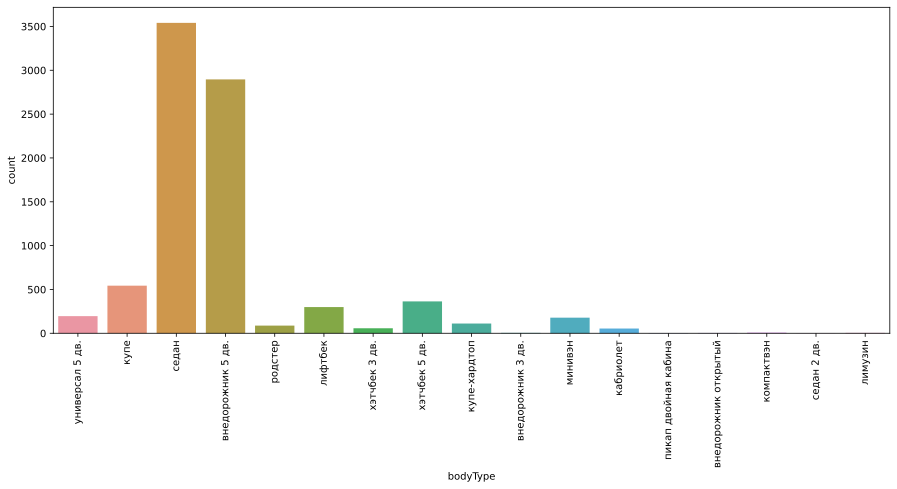

In [25]:
show_info_hist(data.bodyType)

In [26]:
data['bodyType'] = data['bodyType'].apply(lambda x: re.findall(r'\w+', x)[0])
data.bodyType=data.bodyType.apply(lambda x: str(x.lower()))

other_cars = ['лимузин','седан 2 дв.','компактвэн','внедорожник открытый','пикап двойная кабина','внедорожник 3 дв.']
data['bodyType'] = data['bodyType'].apply(lambda x: 'другое' if x in other_cars else x )

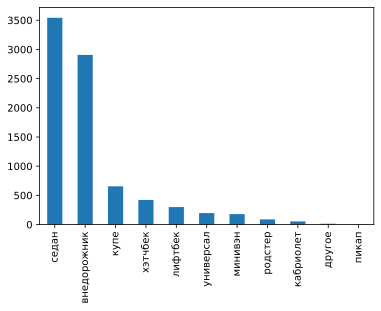

In [27]:
data['bodyType'].value_counts().plot(kind='bar')

# brand

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count     8353
unique       3
top        BMW
freq      3535
Name: brand, dtype: object

Как распределено?
BMW         3535
MERCEDES    2846
AUDI        1972
Name: brand, dtype: int64

Какие значения?
['MERCEDES' 'BMW' 'AUDI']



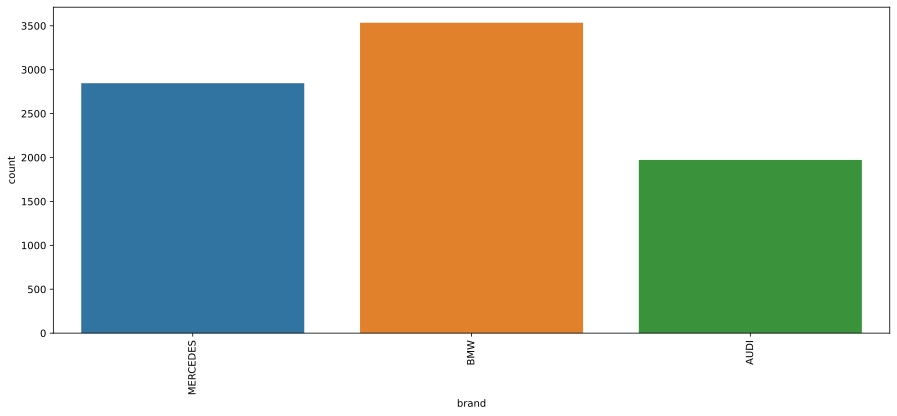

In [28]:
show_info_hist(data.brand)

# Color

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count       8353
unique        16
top       чёрный
freq        3468
Name: color, dtype: object

Как распределено?
чёрный         3468
белый          1607
серый           925
синий           863
серебристый     420
коричневый      386
красный         266
голубой          91
зелёный          86
бежевый          85
фиолетовый       46
пурпурный        38
оранжевый        30
золотистый       24
жёлтый           17
розовый           1
Name: color, dtype: int64

Какие значения?
['чёрный' 'белый' 'пурпурный' 'синий' 'коричневый' 'серый' 'зелёный'
 'серебристый' 'красный' 'оранжевый' 'голубой' 'фиолетовый' 'бежевый'
 'жёлтый' 'золотистый' 'розовый']



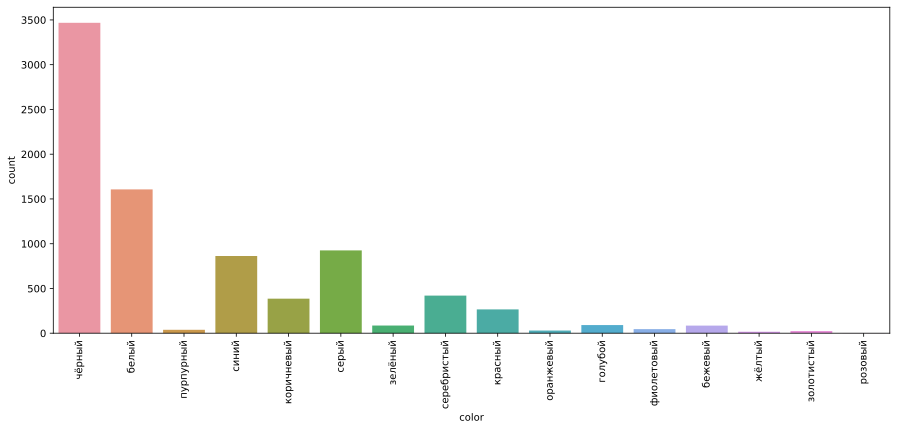

In [29]:
show_info_hist(data.color)

In [30]:
data.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'sample', 'price'],
      dtype='object')

In [31]:
show_info(data.engineDisplacement)

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count        8353
unique         48
top       2.0 LTR
freq         2430
Name: engineDisplacement, dtype: object

Как распределено?
2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
1.4 LTR           106
2.8 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
2.4 LTR            44
3.1 LTR            44
6.2 LTR            40
6.0 LTR            37
5.4 LTR            33
1.2 LTR            33
1.3 LTR            32
2.7 LTR            24
3.6 LTR            23
4.1 LTR            23
1.7 LTR            15
2.3 LTR            14
3.7 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
0.7 LTR             

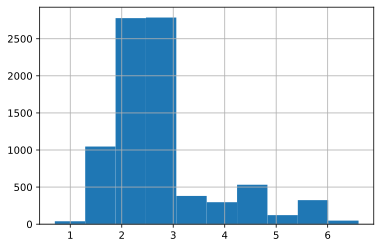

In [32]:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: data['engineDisplacement'].describe().top if x == 'undefined LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: float((x.split(' ')[0])))
data['engineDisplacement'].hist()

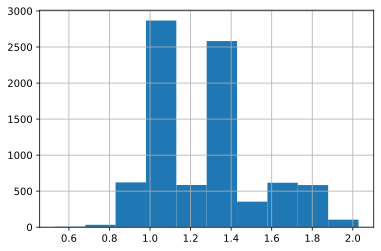

In [33]:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: np.log(x+1))
data['engineDisplacement'].hist()

# enginePower

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count        8353
unique        154
top       184 N12
freq          759
Name: enginePower, dtype: object

Как распределено?
184 N12    759
249 N12    655
190 N12    420
245 N12    355
306 N12    344
          ... 
98 N12       1
700 N12      1
223 N12      1
133 N12      1
591 N12      1
Name: enginePower, Length: 154, dtype: int64

Какие значения?
['220 N12' '313 N12' '218 N12' '136 N12' '190 N12' '340 N12' '245 N12'
 '316 N12' '170 N12' '160 N12' '231 N12' '388 N12' '180 N12' '367 N12'
 '115 N12' '184 N12' '177 N12' '455 N12' '422 N12' '163 N12' '249 N12'
 '272 N12' '224 N12' '122 N12' '557 N12' '333 N12' '306 N12' '156 N12'
 '150 N12' '264 N12' '450 N12' '555 N12' '407 N12' '130 N12' '400 N12'
 '204 N12' '469 N12' '192 N12' '210 N12' '211 N12' '239 N12' '200 N12'
 '350 N12' '420 N12' '300 N12' '381 N12' '265 N12' '258 N12' '390 N12'
 '197 N12' '120 N12' '544 N12' '193 N12' '235 N12' '233 N12' '394 N12'
 '355 N12' '421 N12' '32

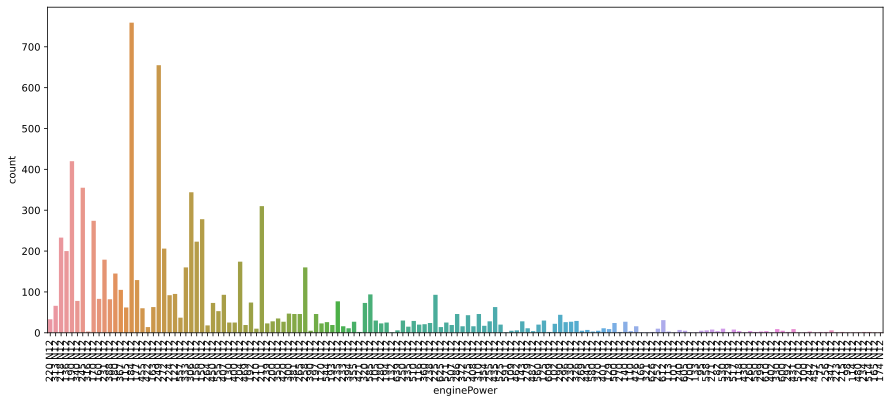

In [34]:
show_info_hist(data.enginePower)

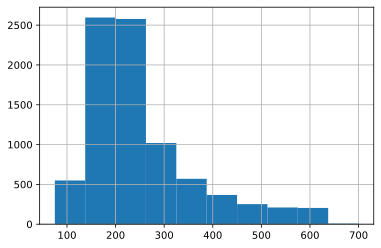

In [35]:
data.enginePower = data.enginePower.apply(lambda x: int(re.findall('(\d+)', str(x))[0]))
data.enginePower.hist()

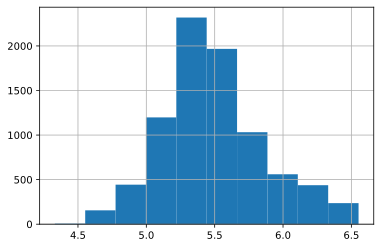

In [36]:
data.enginePower = data.enginePower.apply(lambda x: np.log(x+1))
data.enginePower.hist()

In [37]:
data.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'sample', 'price'],
      dtype='object')

# fuelType

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count       8353
unique         4
top       бензин
freq        6018
Name: fuelType, dtype: object

Как распределено?
бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuelType, dtype: int64

Какие значения?
['бензин' 'дизель' 'гибрид' 'электро']



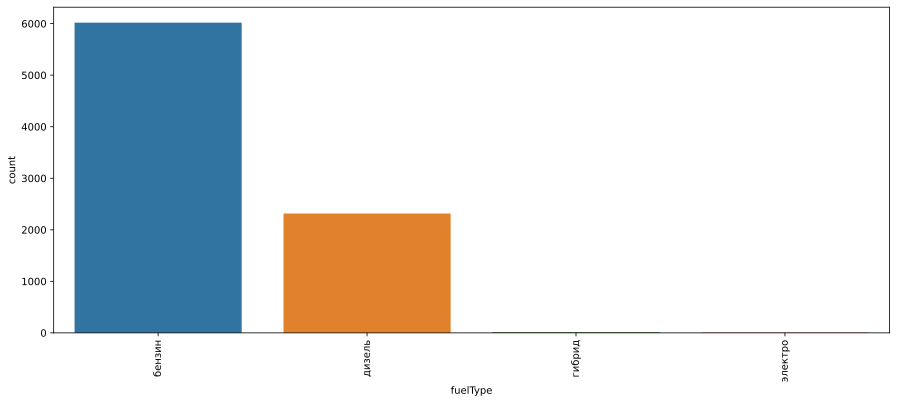

In [38]:
show_info_hist(data.fuelType)

# mileage

In [39]:
show_info(data.mileage)

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count       8353.000000
mean      120362.983479
std        81856.639133
min            1.000000
25%        59246.000000
50%       110384.000000
75%       167084.000000
max      1000000.000000
Name: mileage, dtype: float64

Как распределено?
120000    79
150000    79
180000    77
130000    70
140000    62
          ..
107800     1
80250      1
373        1
41329      1
102402     1
Name: mileage, Length: 3507, dtype: int64

Какие значения?
[350000  15000 166600 ... 232777  33700  21291]


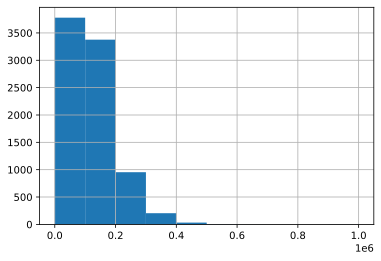

In [40]:
data.mileage.hist()

In [41]:
mile25 = int(data.mileage.quantile(0.25))
mile50 = int(data.mileage.quantile(0.50))
mile75 = int(data.mileage.quantile(0.75))

print('25 квантиль:', mile25)
print('50 квантиль:', mile50)
print('75 квантиль:', mile75)


25 квантиль: 59246
50 квантиль: 110384
75 квантиль: 167084


In [42]:
def mileage_cat(x):
    if x < mile25: x = 1
    elif mile25 < x < mile50: x = 2
    elif mile50 < x < mile75: x = 3
    elif mile75 < x: x = 4
    return x  
data['mileage_cat'] = data['mileage'].apply(lambda x: mileage_cat(x))


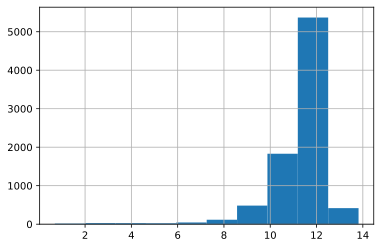

In [43]:
data.mileage = data.mileage.apply(lambda x: np.log(x+1))
data.mileage.hist()

# modelDate

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count    8353.000000
mean     2010.103556
std         5.436914
min      1971.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: modelDate, dtype: float64

Как распределено?
2011    830
2013    739
2014    667
2015    656
2009    655
2008    562
2012    548
2007    542
2016    467
2010    407
2006    345
2005    321
2017    298
2004    242
2018    234
2003    146
2002    135
2019     82
2000     80
2001     76
1999     58
1998     56
1990     48
1994     31
1995     25
1997     16
1996     15
1992     14
1987     11
1984     10
1985      7
1989      5
1982      5
1979      4
1991      4
1977      2
1981      2
1975      2
1988      2
1993      1
1986      1
1971      1
1976      1
Name: modelDate, dtype: int64

Какие значения?
[1984 2011 2005 2016 2009 2008 2007 1989 2001 2006 2013 2014 2015 2004
 2017 2018 2012 2003 2019 2010 2000 1990 2002 1998 1993 1994 1999 1995
 1971 1996 1985 197

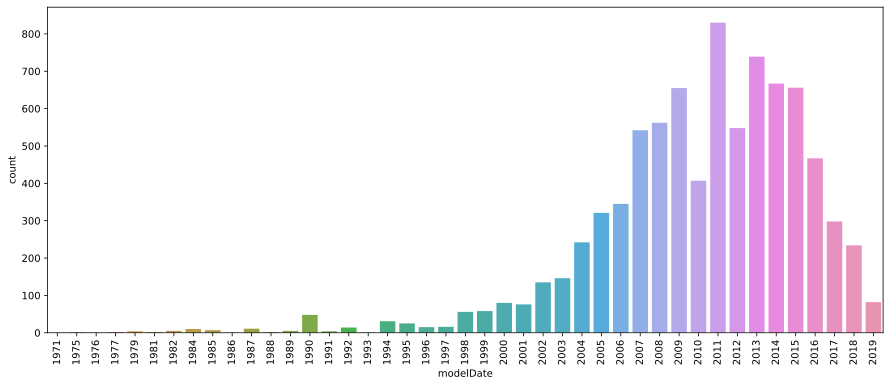

In [44]:
show_info_hist(data.modelDate)

In [45]:
data['how_old'] = data['modelDate'].apply(lambda x: pd.Timestamp.today().year - x)
data['mile_per_year'] = np.exp(data['mileage']) / data.how_old

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count    8353.000000
mean       10.896444
std         5.436914
min         2.000000
25%         7.000000
50%        10.000000
75%        14.000000
max        50.000000
Name: how_old, dtype: float64

Как распределено?
10    830
8     739
7     667
6     656
12    655
13    562
9     548
14    542
5     467
11    407
15    345
16    321
4     298
17    242
3     234
18    146
19    135
2      82
21     80
20     76
22     58
23     56
31     48
27     31
26     25
24     16
25     15
29     14
34     11
37     10
36      7
32      5
39      5
30      4
42      4
33      2
46      2
40      2
44      2
50      1
35      1
45      1
28      1
Name: how_old, dtype: int64

Какие значения?
[37 10 16  5 12 13 14 32 20 15  8  7  6 17  4  3  9 18  2 11 21 31 19 23
 28 27 22 26 50 25 36 46 29 24 34 42 30 39 35 33 40 44 45]



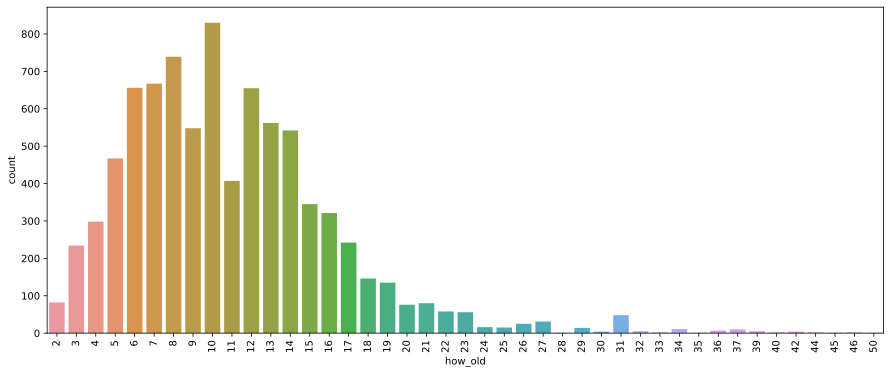

In [46]:
show_info_hist(data.how_old)

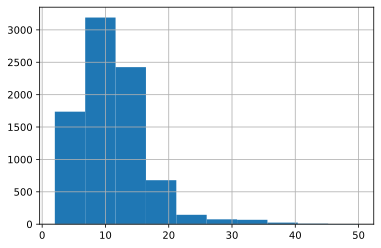

In [47]:
data.how_old.hist()

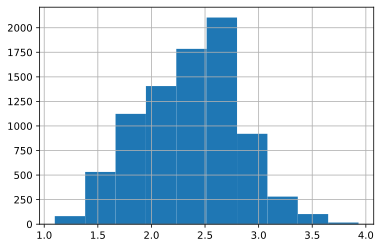

In [48]:
data.how_old = data.how_old.apply(lambda x: np.log(x+1))
data.how_old.hist()

In [49]:
show_info(data.mile_per_year)

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count     8353.000000
mean     10743.807053
std       5628.742476
min          0.285714
25%       7000.166667
50%      10469.818182
75%      14037.625000
max      76923.076923
Name: mile_per_year, dtype: float64

Как распределено?
11538.538462    19
14166.750000    13
12000.100000    13
11250.062500    12
14000.100000    12
                ..
10975.250000     1
16706.000000     1
7583.500000      1
3224.250000      1
512.000000       1
Name: mile_per_year, Length: 5772, dtype: int64

Какие значения?
[ 9459.48648649  1500.1        10412.5625     ... 14548.625
  4212.625        788.59259259]


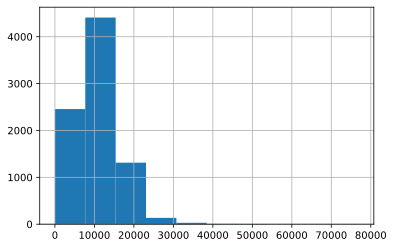

In [50]:
data.mile_per_year.hist()

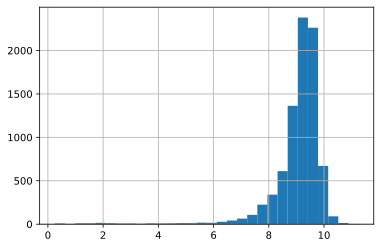

In [51]:
data.mile_per_year = data.mile_per_year.apply(lambda x: np.log(x+1))
data.mile_per_year.hist(bins=30)

In [52]:
mod_d25 = int(data.modelDate.quantile(0.25))
mod_d50 = int(data.modelDate.quantile(0.50))
mod_d75 = int(data.modelDate.quantile(0.75))

def modelDate_cat(x):
    if x < mod_d25: x = 1
    elif mod_d25 < x < mod_d50: x = 2
    elif mod_d50 < x < mod_d75: x = 3
    elif mod_d75 < x: x = 4
    return x  
data['modelDate_cat'] = data['modelDate'].apply(lambda x: modelDate_cat(x))

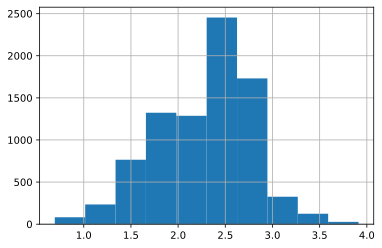

In [53]:
data.modelDate = data.modelDate.apply(lambda x: np.log(2021 -x))
data.modelDate.hist()

In [54]:
data.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'sample', 'price', 'mileage_cat', 'how_old', 'mile_per_year',
       'modelDate_cat'],
      dtype='object')

# Name

In [55]:
show_info(data.name)

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count                          8353
unique                          976
top       35i 3.0 AT (306 л.с.) 4WD
freq                            151
Name: name, dtype: object

Как распределено?
35i 3.0 AT (306 л.с.) 4WD      151
2.0 AMT (211 л.с.) 4WD         145
200 2.0 AT (184 л.с.)          137
30d 3.0d AT (249 л.с.) 4WD     109
400 3.0 AT (333 л.с.) 4WD       97
                              ... 
63 AMG 5.5 AT (557 л.с.)         1
300 3.5 AT (250 л.с.) 4WD        1
200 CDI 2.1d AMT (136 л.с.)      1
2.4 AT (165 л.с.)                1
240 2.6 AT (170 л.с.) 4WD        1
Name: name, Length: 976, dtype: int64

Какие значения?
['300 3.0 AT (220 л.с.)' '640d xDrive 3.0d AT (313 л.с.) 4WD'
 '325xi 2.5 AT (218 л.с.) 4WD' '318i 2.0 AT (136 л.с.)'
 '520d xDrive 2.0d AT (190 л.с.) 4WD' '540i xDrive 3.0 AT (340 л.с.) 4WD'
 '3.0d AT (245 л.с.) 4WD' '350 3.5 AT (316 л.с.)' '1.8 CVT (170 л.с.)'
 '1.8 CVT (160 л.с.)' '300 3.0 AT (231 л.с.)' '320i

In [56]:
data['xdrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)
data['xdrive'].value_counts()

0    7414
1     939
Name: xdrive, dtype: int64

Сколько пропусков? 1

Процент пропусков? 0.011971746677840296%

Описание:
count            8352
unique              3
top       3 или более
freq             3311
Name: Владельцы, dtype: object

Как распределено?
3 или более    3311
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64

Какие значения?
['3 или более' '1\xa0владелец' '2\xa0владельца' nan]



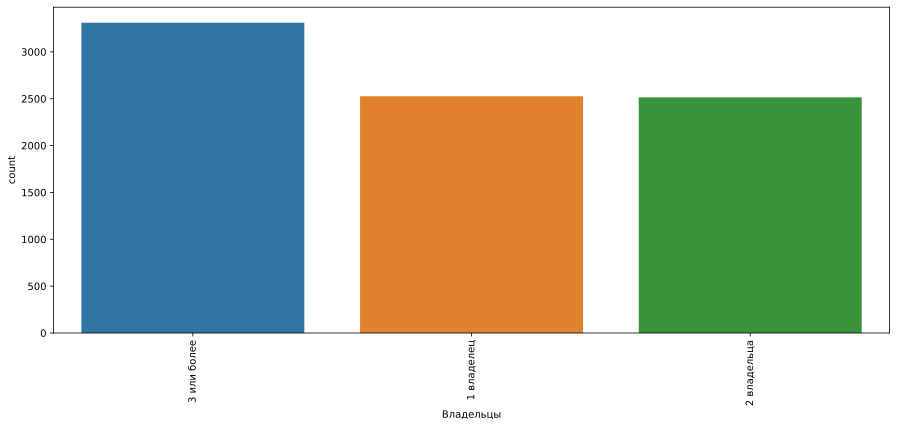

In [57]:
show_info_hist(data.Владельцы)

In [58]:
'''Удалим'''
data.drop(['Владение'], axis=1, inplace=True)

In [59]:
data.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'sample',
       'price', 'mileage_cat', 'how_old', 'mile_per_year', 'modelDate_cat',
       'xdrive'],
      dtype='object')

In [60]:
show_info(data['price'])

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count    8.353000e+03
mean     1.519804e+06
std      1.873130e+06
min      0.000000e+00
25%      4.600000e+05
50%      1.030000e+06
75%      1.900000e+06
max      2.390000e+07
Name: price, dtype: float64

Как распределено?
0.0           1671
950000.0        76
1100000.0       73
1200000.0       71
850000.0        68
              ... 
3195000.0        1
685850.0         1
13498000.0       1
1294000.0        1
1594000.0        1
Name: price, Length: 1629, dtype: int64

Какие значения?
[      0.  599000.  850000. ... 4359000. 1179221.  796000.]


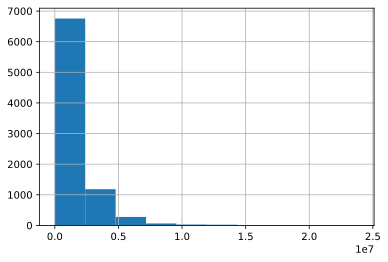

In [61]:
data.price.hist()

In [62]:
price25 = int(data.price.quantile(0.25))
price50 = int(data.price.quantile(0.50))
price75 = int(data.price.quantile(0.75))

def price_cat(x):
    if x < mod_d25: x = 1
    elif price25 < x < price50: x = 2
    elif price50 < x < price75: x = 3
    elif price75 < x: x = 4
    return x  
data['price_cat'] = data['price'].apply(lambda x: price_cat(x))

In [63]:
# data.price = data.price.apply(lambda x: np.sqrt(x+1))
# data.price.hist()

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   float64
 5   enginePower           8353 non-null   float64
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   float64
 8   modelDate             8353 non-null   float64
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [65]:
#обновляем список категориальных
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'xdrive', 'numberOfDoors',
                        'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'mileage_cat', 
                        'modelDate_cat','price_cat']

#обновляем список числовых признаков
numerical_features = ['mileage', 'modelDate', 'enginePower', 'engineDisplacement', 'productionDate', 'how_old','mile_per_year']

In [66]:
corr = data[numerical_features].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,mileage,modelDate,enginePower,engineDisplacement,productionDate,how_old,mile_per_year
mileage,1.000,0.642,-0.147,0.023,-0.554,0.632,0.928
modelDate,0.642,1.000,-0.092,0.187,-0.907,0.999,0.312
enginePower,-0.147,-0.092,1.000,0.874,0.074,-0.092,-0.140
engineDisplacement,0.023,0.187,0.874,1.000,-0.217,0.191,-0.065
productionDate,-0.554,-0.907,0.074,-0.217,1.000,-0.920,-0.246
how_old,0.632,0.999,-0.092,0.191,-0.920,1.000,0.299
mile_per_year,0.928,0.312,-0.140,-0.065,-0.246,0.299,1.000


In [67]:
data.description.head()

0    Всем привет!\n\nПродам эксклюзивный проект 124...
1    Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2    Машина тут продаётся не в первый раз, НО! Толь...
3    Автомобиль в отличном состоянии, весь в родной...
4    Немка! с бесключивым доступом и камерой заднег...
Name: description, dtype: object

In [68]:
# Зададим переменной количество наиболее частов встречающихся слов, которое хотим оставить
N_WORDS = 400

# Приведем значения к str
data['description'] = data['description'].astype('str')
# Разбиваем reviewText на список слов, предварительно приводим текст к нижнему регистру
data['description_word'] = data['description'].apply(
    lambda x: re.sub("[^\w]", " ",  x.lower()).split())

# Создаем пустой список, в который будут добавляться все слова
all_words = []

# Добавляем слова каждой записи в общий список
for words in data.description_word:
    # разбиваем текст на слова, предварительно приводим к нижнему регистру
    all_words.extend(words)

# Считаем частоту слов в датасете
cnt = Counter()
for word in all_words:
    cnt[word] += 1

# Оставим топ N_WORDS слов
top_words = []
for i in range(0, len(cnt.most_common(N_WORDS))):
    words = cnt.most_common(N_WORDS)[i][0]
    top_words.append(words)

# Удаляем дубликаты из all_words
all_words = list(dict.fromkeys(all_words))

print('Всего слов ', len(all_words))
print('Топ', N_WORDS, 'слов: ', top_words)

Всего слов  38020
Топ 400 слов:  ['в', 'и', 'с', 'на', 'не', 'по', 'система', 'автомобиль', 'все', 'для', 'автомобиля', 'от', 'до', 'при', 'пробегом', 'у', '2', 'состоянии', 'без', 'авто', 'салон', 'пакет', 'за', 'машина', 'автомобилей', 'сидений', 'птс', 'безопасности', 'то', 'bmw', '000', 'из', 'более', 'автомобили', 'водителя', 'комплектация', 'есть', '1', 'сиденья', 'года', 'комплект', 'только', 'дилера', 'салона', 'пробег', 'контроль', 'фары', 'кредит', '6', 'диски', 'км', 'лет', 'передние', '3', 'руля', 'датчик', 'пассажира', 'оригинал', 'а', 'подушки', 'мы', '9', 'подогрев', 'заднего', 'состояние', 'обогрев', 'вас', '5', 'обслуживание', 'зеркал', 'торг', 'дтп', 'м', 'рольф', 'официального', 'условия', 'отличном', 'amg', 'что', 'или', 'вашего', 'я', 'как', 'ваш', 'задние', 'климат', 'владелец', 'задний', 'электропривод', 'нет', 'обмен', '4', 'покупке', 'гарантия', 'официальный', 'два', 'полностью', 'юридической', 'замена', 'mercedes', 'комплекта', 'обмене', 'продаю', 'задних', 'ч

Видно,что добавленные фичи имеют большую корреляцию с данными. Нехорошо, но пока оставим и посмотрим.

In [69]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df = df_input.copy()
    
    # Кожа
    df['saloon']= df['description_word'].apply(lambda x: 
                                                1 if ('кожа' or 'кожаная') in x else 0)
    # Подогрев
    df['heating']= df['description_word'].apply(lambda x: 
                                                1 if ('подогрев') in x else 0)
    # Каско
    df['casko']= df['description_word'].apply(lambda x: 
                                                1 if ('каско') in x else 0)
    # USB-порт
    df['usb']= df['description_word'].apply(lambda x: 
                                                1 if ('usb') in x else 0)
    # Салон
    df['saloon']= df['description_word'].apply(lambda x: 
                                                1 if ('темный' and 'салон') in x else 0)
    # Картер
    df['carter']= df['description_word'].apply(lambda x: 
                                                    1 if ('защита' and 'картера') in x else 0)
    # AБС
    df['ABS']= df['description_word'].apply(lambda x: 
                                                    1 if ('антиблокировочная' and 'система') in x else 0)
    # Подушка безопасности
    df['airbags']= df['description_word'].apply(lambda x: 
                                                    1 if ('подушки' and 'безопасности') in x else 0)
    # Иммобилайзер
    df['immob']= df['description_word'].apply(lambda x: 
                                                    1 if ('иммобилайзер') in x else 0)
    # Замок
    df['central_locking']= df['description_word'].apply(lambda x: 
                                                    1 if ('центральный' and 'замок') in x else 0)
    # Компьютер
    df['on_board_computer']= df['description_word'].apply(lambda x: 
                                                    1 if ('бортовой' and 'компьютер') in x else 0)
    # Круиз контроль
    df['cruise_control']= df['description_word'].apply(lambda x: 
                                                    1 if ('круиз-контроль') in x else 0)
    # Климат контроль
    df['climat_control']= df['description_word'].apply(lambda x: 
                                                    1 if ('климат-контроль') in x else 0)
    # Руль
    df['multi_rudder']= df['description_word'].apply(lambda x: 
                                                    1 if ('мультифункциональный' and 'руль') in x else 0)
    # Усиление руля
    df['power_steering']= df['description_word'].apply(lambda x: 
                                                    1 if ('гидроусилитель' or 'гидро' or 'усилитель' and 'руля') in x else 0)
    # Датчики
    df['light_and_rain_sensors']= df['description_word'].apply(lambda x: 
                                                    1 if ('датчики' and 'света' and 'дождя') in x else 0)
    # Карбоновый обвес
    df['сarbon_body_kits']= df['description_word'].apply(lambda x: 
                                                    1 if ('карбоновые' and 'обвесы') in x else 0)
    # Диффузор
    df['rear_diffuser_rkp']= df['description_word'].apply(lambda x: 
                                                    1 if ('задний' and 'диффузор') in x else 0)
    # Доводчик дверей
    df['door_closers']= df['description_word'].apply(lambda x: 
                                                    1 if ('доводчики' and 'дверей') in x else 0)
    # Камера заднего вида
    df['rear_view_camera']= df['description_word'].apply(lambda x: 
                                                    1 if ('камера' or 'видеокамера' and 'заднего' and 'вида') in x else 0)
    # amg
    df['amg']= df['description_word'].apply(lambda x: 
                                                    1 if ('amg') in x else 0)
    # Фары
    df['bi_xenon_headlights']= df['description_word'].apply(lambda x: 
                                                    1 if ('биксеноновые' and 'фары') in x else 0)
    
    df['from_salon']= df['description_word'].apply(lambda x: 
                                                    1 if ('рольф' or 'панавто' or 'дилер' or 'кредит' or 'ликвидация') in x else 0)
    # Диски
    df['alloy_wheels']= df['description_word'].apply(lambda x: 
                                                    1 if ('легкосплавные' or 'колесные' or 'диски') in x else 0)
    # Парктроник
    df['parking_sensors']= df['description_word'].apply(lambda x: 
                                                    1 if ('парктроник' or 'парктронник') in x else 0)
    # Повреждение поверхности
    df['dents']= df['description_word'].apply(lambda x: 
                                                    1 if ('вмятины' or 'вмятина' or 'царапина' or 'царапины' or 'трещина') in x else 0)
    # Панорамная крыша
    df['roof_with_panoramic_view']= df['description_word'].apply(lambda x: 
                                                    1 if ('панорамная' and 'крыша') in x else 0)

    # Обивка салона
    df['upholstery'] = df['description_word'].apply(lambda x: 1 if ('обивка' and 'салон') in x else 0)

    # Подогрев сидения
    df['heated_seat'] = df['description_word'].apply(lambda x: 1 if ('подогрев' and 'сидение') in x else 0)

    # Датчик дождя
    df['rain_sensor'] = df['description_word'].apply(lambda x: 1 if ('датчик' and 'дождь') in x else 0)

    # Официальный диллер
    df['official_dealer'] = df['description_word'].apply(lambda x: 1 if ('официальный' and 'диллер') in x else 0)

    # Хорошее состояние
    df['good_condition'] = df['description_word'].apply(lambda x: 1 if ('хороший' and 'состояние') in x else 0)

    # Отличное состояние
    df['excellent_condition'] = df['description_word'].apply(lambda x: 1 if ('отличный' and 'состояние') in x else 0)
    
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output = df.copy()
    df_output.drop(['description','sell_id','description_word'], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration','name'], axis = 1, inplace=True)
    
    return df_output

In [70]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,sample,price,how_old,mile_per_year,saloon,heating,casko,usb,carter,ABS,airbags,immob,central_locking,on_board_computer,cruise_control,climat_control,multi_rudder,power_steering,light_and_rain_sensors,сarbon_body_kits,rear_diffuser_rkp,door_closers,rear_view_camera,amg,bi_xenon_headlights,from_salon,alloy_wheels,parking_sensors,dents,roof_with_panoramic_view,upholstery,heated_seat,rain_sensor,official_dealer,good_condition,excellent_condition,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,xdrive_0,xdrive_1,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_-1,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,mileage_cat_0,mileage_cat_1,mileage_cat_2,mileage_cat_3,mileage_cat_4,mileage_cat_5,mileage_cat_6,modelDate_cat_0,modelDate_cat_1,modelDate_cat_2,modelDate_cat_3,modelDate_cat_4,modelDate_cat_5,modelDate_cat_6,price_cat_0,price_cat_1,price_cat_2,price_cat_3,price_cat_4,price_cat_5,price_cat_6,price_cat_7,price_cat_8,price_cat_9,price_cat_10,price_cat_11,price_cat_12,price_cat_13,price_cat_14,price_cat_15,price_cat_16,price_cat_17,price_cat_18,price_cat_19,price_cat_20,price_cat_21,price_cat_22,price_cat_23,price_cat_24,price_cat_25,price_cat_26,price_cat_27,price_cat_28,price_cat_29,price_cat_30,price_cat_31,price_cat_32,price_cat_33,price_cat_34,price_cat_35,price_cat_36,price_cat_37,price_cat_38,price_cat_39,price_cat_40,price_cat_41,price_cat_42,price_cat_43,price_cat_44,price_cat_45,price_cat_46,price_cat_47,price_cat_48,price_cat_49,price_cat_50,price_cat_51,price_cat_52,price_cat_53,price_cat_54,price_cat_55,price_cat_56,price_cat_57,price_cat_58,price_cat_59,price_cat_60,price_cat_61,price_cat_62,price_cat_63,price_cat_64,price_cat_65,price_cat_66,price_cat_67,price_cat_68,price_cat_69,price_cat_70,price_cat_71
7399,0.379283,0.528676,0.829686,0.389

In [71]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 304 entries, engineDisplacement to price_cat_71
dtypes: float64(8), int64(33), uint8(263)
memory usage: 4.7 MB


## Split data

In [72]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [73]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 303 entries, engineDisplacement to price_cat_71
dtypes: float64(8), int64(32), uint8(263)
memory usage: 964.4 KB


# Model 2: CatBoostRegressor

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [75]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          learning_rate = 0.05,  
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                          od_type='IncToDec'
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.9606487	test: 0.9851196	best: 0.9851196 (0)	total: 57.1ms	remaining: 4m 45s
100:	learn: 0.2097086	test: 0.2180647	best: 0.2180647 (100)	total: 464ms	remaining: 22.5s
200:	learn: 0.1566038	test: 0.1667654	best: 0.1667573 (198)	total: 868ms	remaining: 20.7s
300:	learn: 0.1426672	test: 0.1527999	best: 0.1527928 (299)	total: 1.27s	remaining: 19.9s
400:	learn: 0.1299330	test: 0.1391628	best: 0.1391628 (400)	total: 1.68s	remaining: 19.2s
500:	learn: 0.1217843	test: 0.1317083	best: 0.1317044 (498)	total: 2.08s	remaining: 18.7s
600:	learn: 0.1129880	test: 0.1235528	best: 0.1235528 (600)	total: 2.8s	remaining: 20.5s
700:	learn: 0.1077059	test: 0.1193911	best: 0.1193625 (698)	total: 3.31s	remaining: 20.3s
800:	learn: 0.1033406	test: 0.1156984	best: 0.1156857 (799)	total: 3.73s	remaining: 19.6s
900:	learn: 0.0998230	test: 0.1133391	best: 0.1133353 (892)	total: 4.15s	remaining: 18.9s
1000:	learn: 0.0965427	test: 0.1111007	best: 0.1111007 (1000)	total: 4.55s	remaining: 18.2s
1100:	learn

In [76]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

train_predict_catboost = model.predict(X_train)
print(f"TRAIN mape: {(mape(y_train, train_predict_catboost))*100:0.2f}%")

TEST mape: 10.01%
TRAIN mape: 5.22%


### Хорошее улучшение относительно самой простой модели

In [77]:
# print(f"Test MAE: {mean_absolute_error(y_test,test_predict_catboost)*100:0.3f}%")
# print(f"TRAIN MAE: {mean_absolute_error(y_train,train_predict_catboost)*100:0.3f}%")
# print()
# print(f"Test MSE: {mean_squared_error(y_test, test_predict_catboost)*100:0.3f}%")
# print(f"TRAIN MSE: {mean_squared_error(y_train, train_predict_catboost)*100:0.3f}%")


### Submission

In [78]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [79]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,how_old,mile_per_year,saloon,heating,casko,usb,carter,ABS,airbags,immob,central_locking,on_board_computer,cruise_control,climat_control,multi_rudder,power_steering,light_and_rain_sensors,сarbon_body_kits,rear_diffuser_rkp,door_closers,rear_view_camera,amg,bi_xenon_headlights,from_salon,alloy_wheels,parking_sensors,dents,roof_with_panoramic_view,upholstery,heated_seat,rain_sensor,official_dealer,good_condition,excellent_condition,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,xdrive_0,xdrive_1,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_-1,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,mileage_cat_0,mileage_cat_1,mileage_cat_2,mileage_cat_3,mileage_cat_4,mileage_cat_5,mileage_cat_6,modelDate_cat_0,modelDate_cat_1,modelDate_cat_2,modelDate_cat_3,modelDate_cat_4,modelDate_cat_5,modelDate_cat_6,price_cat_0,price_cat_1,price_cat_2,price_cat_3,price_cat_4,price_cat_5,price_cat_6,price_cat_7,price_cat_8,price_cat_9,price_cat_10,price_cat_11,price_cat_12,price_cat_13,price_cat_14,price_cat_15,price_cat_16,price_cat_17,price_cat_18,price_cat_19,price_cat_20,price_cat_21,price_cat_22,price_cat_23,price_cat_24,price_cat_25,price_cat_26,price_cat_27,price_cat_28,price_cat_29,price_cat_30,price_cat_31,price_cat_32,price_cat_33,price_cat_34,price_cat_35,price_cat_36,price_cat_37,price_cat_38,price_cat_39,price_cat_40,price_cat_41,price_cat_42,price_cat_43,price_cat_44,price_cat_45,price_cat_46,price_cat_47,price_cat_48,price_cat_49,price_cat_50,price_cat_51,price_cat_52,price_cat_53,price_cat_54,price_cat_55,price_cat_56,price_cat_57,price_cat_58,price_cat_59,price_cat_60,price_cat_61,price_cat_62,price_cat_63,price_cat_64,price_cat_65,price_cat_66,price_cat_67,price_cat_68,price_cat_69,price_cat_70,price_cat_71
7320,0.945084,0.886702,0.855429,0.581508,0.763158,

## Simple Dense NN

In [80]:
model = Sequential()
model.add(L.Dense(1024, input_dim=X_train.shape[1], activation="relu"))  #changed to 1024
model.add(L.Dropout(0.5))
model.add(L.Dense(512, activation="relu"))  #added
model.add(L.Dropout(0.5))                   #added
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [81]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              310272    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2

In [82]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [83]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [84]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

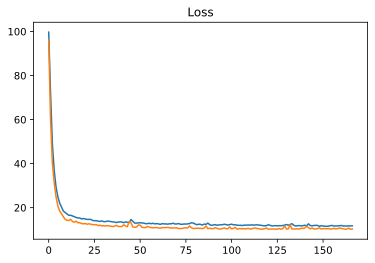

In [85]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [86]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [87]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

train_predict_nn1 = model.predict(X_train)
print(f"TRAIN mape: {(mape(y_train, train_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 10.33%
TRAIN mape: 7.68%


In [88]:
# print(f"Test MAE: {mean_absolute_error(y_test,test_predict_nn1[:,0])*100:0.3f}%")
# print(f"TRAIN MAE: {mean_absolute_error(y_train,train_predict_nn1[:,0])*100:0.3f}%")
# print()
# print(f"Test MSE: {mean_squared_error(y_test, test_predict_nn1[:,0])*100:0.3f}%")
# print(f"TRAIN MSE: {mean_squared_error(y_train, train_predict_nn1[:,0])*100:0.3f}%")

In [89]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [90]:
data.description.head()

0    Всем привет!\n\nПродам эксклюзивный проект 124...
1    Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2    Машина тут продаётся не в первый раз, НО! Толь...
3    Автомобиль в отличном состоянии, весь в родной...
4    Немка! с бесключивым доступом и камерой заднег...
Name: description, dtype: object

In [91]:
data['description'] = data.description.str.replace('•','')
data['description'] = data.description.str.replace('–','')
data['description'] = data.description.str.replace('∙','')
data['description'] = data.description.str.replace('☑️','')
data['description'] = data.description.str.replace('✔','')
data['description'] = data.description.str.replace('➥','')
data['description'] = data.description.str.replace('●','')
data['description'] = data.description.str.replace('☛','')
data['description'] = data.description.str.replace('✅','')
data['description'] = data.description.str.replace('———————————————————————————','')
data['description'] = data.description.str.replace('•','')

data['description'] = data['description'].str.lower()


data['description'] = data.description.str.replace('автомобиль в отличном состоянии','автомобильвотличномсостоянии')
data['description'] = data.description.str.replace('машина в отличном состаянии', 'автомобильвотличномсостоянии')
data['description'] = data.description.str.replace('машина в отличном состоянии', 'автомобильвотличномсостоянии')
data['description'] = data.description.str.replace('продаю машину в отличном состоянии', 'автомобильвотличномсостоянии')
data['description'] = data.description.str.replace('авто в идеальном состоянии', 'автомобильвотличномсостоянии')

In [92]:
def lemmited(description):
    description_split = description.split(" ")
    for word in description_split:
        p = morph.parse(word)[0]
        description = description.replace(word,p.normal_form)
    return description

In [93]:
from nltk.corpus import stopwords

#удалим стоп-слова
filtered_tokens = dict()
stop_words = stopwords.words("russian")
for word in stop_words:
    data['description'] = data.description.str.replace(' '+word+' ',' ')
    
  # леммитизация
morph = pymorphy2.MorphAnalyzer()    
data['description'] = data['description'].apply(lemmited)

In [94]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [95]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [96]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.35 s, sys: 5.75 ms, total: 1.35 s
Wall time: 1.36 s


In [97]:
tokenize.word_index

{'автомобиль': 1,
 'система': 2,
 'пробег': 3,
 'задний': 4,
 'передний': 5,
 'салон': 6,
 'сидение': 7,
 '2': 8,
 'комплект': 9,
 'машина': 10,
 'год': 11,
 'официальный': 12,
 'ваш': 13,
 'кредит': 14,
 'новый': 15,
 'авто': 16,
 'пакет': 17,
 'дилер': 18,
 'состояние': 19,
 'безопасность': 20,
 'гарантия': 21,
 'диск': 22,
 'птс': 23,
 'обмен': 24,
 'контроль': 25,
 'bmw': 26,
 '000': 27,
 'полный': 28,
 'покупка': 29,
 'датчик': 30,
 'колесо': 31,
 '1': 32,
 'водитель': 33,
 'продажа': 34,
 'состоянии': 35,
 'м': 36,
 'подушка': 37,
 '6': 38,
 'комплектация': 39,
 '3': 40,
 'обслуживание': 41,
 'проверка': 42,
 'юридический': 43,
 'оригинал': 44,
 'км': 45,
 'резина': 46,
 'руль': 47,
 'хороший': 48,
 'любой': 49,
 'технический': 50,
 'двигатель': 51,
 'масло': 52,
 'торг': 53,
 'условие': 54,
 'обогрев': 55,
 'наш': 56,
 '9': 57,
 'подогрев': 58,
 'все': 59,
 'владелец': 60,
 'замена': 61,
 'дополнительный': 62,
 'сервисный': 63,
 'пройти': 64,
 'рулевой': 65,
 'купить': 66,
 '5':

In [98]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.3 s, sys: 2.84 ms, total: 1.31 s
Wall time: 1.3 s


In [99]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

 автомобиль проверить 110 пунктам
 автокредит специальный ставка 13,7%

ауди центр север, официальный дилер audi, входящий группа компания рольф являться один крупный дилер европе, предлагать ряд услуга покупка продажа автомобиль пробег.

ич протяжение многий год наш дилерский центр являться лидер продажа автомобиль пробег среди дилер audi россия предоставлять клиент самый большой выбор автомобиль пробег audi другой марок.
каждый автомобиль проходить тщательный диагностик подготовку, гарантировать находиться отличный состоянии.
чтоба убедиться правильный выборе, возможность пройти тест-драйв ― ознакомительный поездка интересовать автомобиле.
в смочь ознакомиться автомобиль выходить дом  наш менеджер провести online презентация видеозвонок показать выбрать автомобиль.
такж ауди центр север представлять уникальный предложение кредитование автомобиль пробег индивидуальный условиех. специалист компания  подобрать хороший условие кредитования.

более 6 000 проверитьных автомобиль пробег 

### RNN NLP

In [100]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(512, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(256, return_sequences=True))  #added
model_nlp.add(L.Dropout(0.5))                      #added
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [101]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(128, activation="relu"))  #added
model_mlp.add(L.Dropout(0.5))                   #added

### Multiple Inputs NN

In [102]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [103]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     9050112     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 512)     1574912     embedding[0][0]                  
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 256, 512)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [104]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [105]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [106]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 8s 671ms/step - loss: 99.9021 - MAPE: 99.9021 - val_loss: 98.1823 - val_MAPE: 98.1823
Epoch 2/500
12/12 [==============================] - 7s 582ms/step - loss: 76.5618 - MAPE: 76.5618 - val_loss: 59.8728 - val_MAPE: 59.8728
Epoch 3/500
12/12 [==============================] - 7s 583ms/step - loss: 49.0511 - MAPE: 49.0511 - val_loss: 38.8073 - val_MAPE: 38.8073
Epoch 4/500
12/12 [==============================] - 7s 563ms/step - loss: 37.1332 - MAPE: 37.1332 - val_loss: 28.4491 - val_MAPE: 28.4491
Epoch 5/500
12/12 [==============================] - 7s 570ms/step - loss: 29.1236 - MAPE: 29.1236 - val_loss: 23.9249 - val_MAPE: 23.9249
Epoch 6/500
12/12 [==============================] - 7s 576ms/step - loss: 24.9529 - MAPE: 24.9529 - val_loss: 19.8682 - val_MAPE: 19.8682
Epoch 7/500
12/12 [==============================] - 7s 573ms/step - loss: 22.5411 - MAPE: 22.5411 - val_loss: 18.8406 - val_MAPE: 18.8406
Epoch 8/500
12/12 [========

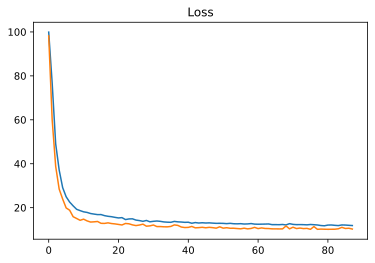

In [107]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [108]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [109]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

train_predict_nn2 = model.predict([text_train_sequences, X_train])
print(f"TRAIN mape: {(mape(y_train, train_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 10.26%
TRAIN mape: 8.23%


In [110]:
# print(f"Test MAE: {mean_absolute_error(y_test,test_predict_nn2[:,0])*100:0.3f}%")
# print(f"TRAIN MAE: {mean_absolute_error(y_train,train_predict_nn2[:,0])*100:0.3f}%")
# print()
# print(f"Test MSE: {mean_squared_error(y_test, test_predict_nn2[:,0])*100:0.3f}%")
# print(f"TRAIN MSE: {mean_squared_error(y_train, train_predict_nn2[:,0])*100:0.3f}%")

In [111]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

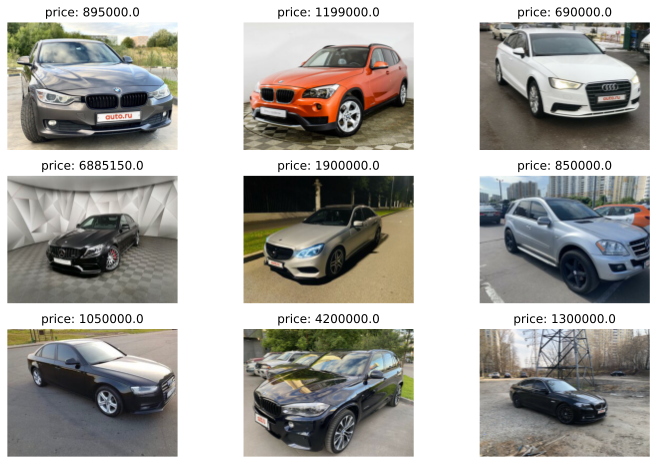

In [112]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [113]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

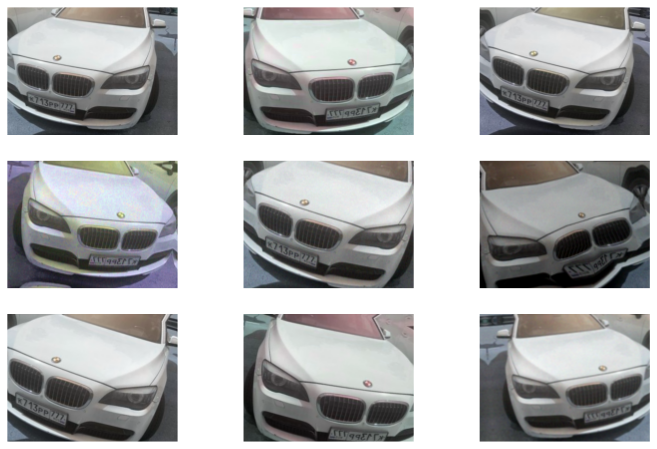

In [114]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [115]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [116]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [117]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [118]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', 
                                                                       include_top = False, 
                                                                       input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 1s 0us/step


In [119]:
# Fine-tuning.
efficientnet_model.trainable = True

fine_tune_at = len(efficientnet_model.layers)//2

for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [120]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff044a311d0> True
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x7ff044a23490> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7ff044a4afd0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7ff041318550> True
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff04483f210> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7ff488035e90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7ff044f42b10> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7ff0449d47d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7ff04482d6d0> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7ff044792290> True
<tensorflow.python.keras.layers.core.Dense object at 0x7ff044839f50> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7ff0449bbe90> True
<tensorflow.python.keras.layers.core.Dropout obje

In [121]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(1024, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(128, activation = 'relu'),  #added
    L.Dropout(0.5),                     #added
    ])

In [122]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),  #added
    L.Dense(64)       #added
    ])

In [123]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(128, activation="relu")(combinedInput)  #added
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [124]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [125]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [126]:
history = model.fit(train_dataset.batch(30),
                    epochs=60,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/60
190/190 [==============================] - 102s 539ms/step - loss: 34.6285 - MAPE: 34.6285 - val_loss: 20.6978 - val_MAPE: 20.6978
Epoch 2/60
190/190 [==============================] - 95s 503ms/step - loss: 20.0574 - MAPE: 20.0574 - val_loss: 15.7310 - val_MAPE: 15.7310
Epoch 3/60
190/190 [==============================] - 98s 515ms/step - loss: 18.6583 - MAPE: 18.6583 - val_loss: 14673.0117 - val_MAPE: 14673.0117
Epoch 4/60
190/190 [==============================] - 98s 515ms/step - loss: 17.6983 - MAPE: 17.6983 - val_loss: 12.6845 - val_MAPE: 12.6845
Epoch 5/60
190/190 [==============================] - 100s 524ms/step - loss: 16.1469 - MAPE: 16.1469 - val_loss: 14.9316 - val_MAPE: 14.9316
Epoch 6/60
190/190 [==============================] - 101s 531ms/step - loss: 15.6264 - MAPE: 15.6264 - val_loss: 15.3815 - val_MAPE: 15.3815
Epoch 7/60
190/190 [==============================] - 98s 517ms/step - loss: 15.1203 - MAPE: 15.1203 - val_loss: 12.6237 - val_MAPE: 12.6237
Epoc

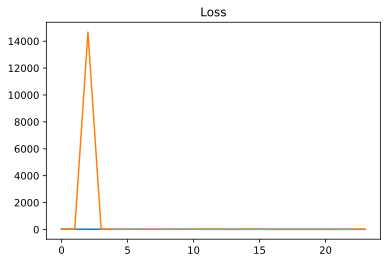

In [127]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [128]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [129]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

train_predict_nn3 = model.predict(train_dataset.batch(30))
print(f"TRAIN mape: {(mape(y_train, train_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.81%
TRAIN mape: 11.52%


In [130]:
# print(f"Test MAE: {mean_absolute_error(y_test,test_predict_nn3[:,0])*100:0.3f}%")
# print(f"TRAIN MAE: {mean_absolute_error(y_train,train_predict_nn3[:,0])*100:0.3f}%")
# print()
# print(f"Test MSE: {mean_squared_error(y_test, test_predict_nn3[:,0])*100:0.3f}%")
# print(f"TRAIN MSE: {mean_squared_error(y_train, train_predict_nn3[:,0])*100:0.3f}%")

In [131]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [132]:
blend_predict_test = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict_test))*100:0.2f}%")

blend_predict_train = (train_predict_catboost + train_predict_nn3[:,0]) / 2
print(f"TRAIN mape: {(mape(y_train, blend_predict_train))*100:0.2f}%")

TEST mape: 9.73%
TRAIN mape: 7.23%


In [133]:
# print(f"Test MAE: {mean_absolute_error(y_test,blend_predict_test)*100:0.3f}%")
# print(f"TRAIN MAE: {mean_absolute_error(y_train, blend_predict_train)*100:0.3f}%")
# print()
# print(f"Test MSE: {mean_squared_error(y_test, blend_predict_test)*100:0.3f}%")
# print(f"TRAIN MSE: {mean_squared_error(y_train, blend_predict_train)*100:0.3f}%")

In [134]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [135]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [136]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [137]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [138]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_18_input (InputLayer)     [(None, 302)]        0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 512)          155136      dense_18_input[0][0]             
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 512)          0           dense_18[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [139]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [140]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 28ms/step - loss: 99.9721 - MAPE: 99.9721 - val_loss: 99.6659 - val_MAPE: 99.6659
Epoch 2/500
12/12 [==============================] - 0s 13ms/step - loss: 97.0409 - MAPE: 97.0409 - val_loss: 86.7721 - val_MAPE: 86.7721
Epoch 3/500
12/12 [==============================] - 0s 13ms/step - loss: 65.5539 - MAPE: 65.5539 - val_loss: 54.8587 - val_MAPE: 54.8587
Epoch 4/500
12/12 [==============================] - 0s 12ms/step - loss: 50.2182 - MAPE: 50.2182 - val_loss: 44.7467 - val_MAPE: 44.7467
Epoch 5/500
12/12 [==============================] - 0s 12ms/step - loss: 42.1068 - MAPE: 42.1068 - val_loss: 38.0407 - val_MAPE: 38.0407
Epoch 6/500
12/12 [==============================] - 0s 9ms/step - loss: 36.1026 - MAPE: 36.1026 - val_loss: 30.9321 - val_MAPE: 30.9321
Epoch 7/500
12/12 [==============================] - 0s 8ms/step - loss: 30.2484 - MAPE: 30.2484 - val_loss: 26.4660 - val_MAPE: 26.4660
Epoch 8/500
12/12 [=================

In [141]:


model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

train_predict_nn_bonus = model.predict([X_train, X_train.productionDate.values])
print(f"TRAIN mape: {(mape(y_train, train_predict_nn_bonus[:,0]))*100:0.2f}%")

print(f"Test MAE: {mean_absolute_error(y_test,test_predict_nn_bonus[:,0])*100:0.3f}%")
print(f"Test MSE: {mean_squared_error(y_test, test_predict_nn_bonus[:,0])*100:0.3f}%")


TEST mape: 10.38%
TRAIN mape: 8.60%
Test MAE: 25779775.187%
Test MSE: 62400414991021.656%


In [142]:
# 